## Importazione e preprocessing

### Importazione pacchetti

In [ ]:
#Stile di visualizzazione plot fatti con matplotlib
%matplotlib inline

#Base
import os
import pandas as pd
import numpy as np
import scipy as sp
import time
import sys

#Visualizzazione
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sn  #Per heatmap

#Preprocessing e altro
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, ParameterGrid, KFold
sys.path.insert(1, './Data')
from preprocessing import preprocessing_diabetes
from preprocessing_v2 import preprocessing_diabetes_v2
from preprocessing_v3 import preprocessing_diabetes_v3
from imblearn.over_sampling import SMOTE

#Modelli
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC as SupportVectorMachineClassifier
from sklearn.neural_network import MLPClassifier

#Metriche
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, make_scorer

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

### Importazione dati e diversi pre-processing

In [3]:
trainingData = pd.read_csv('../Data/diabetes_train.csv')
testData = pd.read_csv('../Data/diabetes_test.csv')

In [5]:
df_train_scal, df_test_scal, y_train, y_test = preprocessing_diabetes_v3(trainingData, testData)
df_train_noFeat, df_test_noFeat, _, _ = preprocessing_diabetes_v3(trainingData, testData, option='Delete')
df_train_PCA, df_test_PCA, _, _ = preprocessing_diabetes_v3(trainingData, testData, option='PCA')
df_train_noSmok, df_test_noSmok, _, _ = preprocessing_diabetes_v3(trainingData, testData, delete_smoking=True)

df_train_scal_os, df_test_scal_os, y_train_os, y_test_os = preprocessing_diabetes_v3(trainingData, testData, oversample=True)
df_train_noFeat_os, df_test_noFeat_os, _, _ = preprocessing_diabetes_v3(trainingData, testData, option='Delete', oversample=True)
df_train_PCA_os, df_test_PCA_os, _, _ = preprocessing_diabetes_v3(trainingData, testData, option='PCA', oversample=True)
df_train_noSmok_os, df_test_noSmok_os, _, _ = preprocessing_diabetes_v3(trainingData, testData, delete_smoking=True, oversample=True)

In [6]:
display(df_train_scal)

,age,bmi,HbA1c_level,blood_glucose_level,Insulin_Sensitivity_Est,BMI_Glucose_Interaction,Random_Lab_Marker,gender,hypertension,heart_disease,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0.894928,-0.176195,0.503722,0.095442,0.476212,-0.055814,-1.175480,1,0,0,False,False,False,True,False
1,0.668110,0.758421,1.541394,-0.072366,0.007480,0.266092,-1.007407,1,1,0,False,False,False,True,False
2,1.034925,0.365698,2.218108,1.701715,0.481892,1.438787,0.651317,1,0,0,False,False,True,False,False
3,0.579111,0.667063,2.104176,0.043478,0.716419,0.317432,-0.953973,1,0,0,False,False,False,True,False
4,1.146937,1.446470,0.321064,0.328064,-0.132528,0.907586,0.423327,1,0,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,-1.205383,0.064420,-0.402472,0.164156,0.179832,0.206146,0.311464,0,0,0,False,False,True,False,False
582,1.134089,-0.535417,-1.650545,0.127452,-2.138018,-0.213306,-0.655270,0,0,0,False,False,False,False,True
583,0.672161,0.122466,-0.008653,-0.142200,-1.439506,-0.080177,0.943590,1,0,1,True,False,False,False,False
584,-0.852201,-0.142217,0.134120,0.917149,0.000000,0.521425,1.180482,0,0,0,False,False,False,False,False


## Multi-Layer Perceptron

In [7]:
random_seed = 42

In [8]:
# Creazione di una sottomappa di viridis, in modo da avere il verde come massimo
viridis = matplotlib.colormaps['viridis'].resampled(280)
newcolors = viridis(np.linspace(0, 1, 280))[:210]
newcmp=matplotlib.colors.ListedColormap(newcolors)

In [ ]:
#Funzione per rappresentare la tabella delle performance sul test
def performances(model,data,y_true,title=None):
    start=time.time()
    y_pred=model.predict(data)
    stop=time.time()
    totalTime=stop-start
    acc = model.score(data, y_true)
    prec = precision_score(y_true, y_pred, average='binary')
    rec = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    df = pd.DataFrame({'Accuracy': [acc], 
                        'Precision': [prec ], 
                        'Recall': [rec ],
                        'F1': [f1 ]
                       },
                      index=[title])
    cmat=pd.DataFrame(confusion_matrix(y_true,y_pred,labels=model.classes_))
    return df,cmat,totalTime

In [ ]:
# Funzione per mostrare la confusion matrix
def heatMapConstr(heatMapMatrices, titles):
    fig,axs=plt.subplots(1,len(titles),figsize=(18,3))
    for i in range(len(titles)):
        normMatrix=heatMapMatrices[i].div(heatMapMatrices[i].sum(axis=1), axis=0)
        ax=axs[i]
        im=ax.imshow(normMatrix,vmin=0,vmax=1,cmap=newcmp)
        ax.set_yticks(range(len(heatMapMatrices[i].index)))
        ax.set_yticklabels(heatMapMatrices[i].index)
        ax.set_xticks(range(len(heatMapMatrices[i].columns)))
        ax.set_xticklabels(heatMapMatrices[i].columns)
        ax.title.set_text(titles[i])
        ax.set_xlabel("predicted")
        ax.set_ylabel("true")
        for a in range(len(heatMapMatrices[i].index)):
            for j in range(len(heatMapMatrices[i].columns)):
                text = ax.text(j, a, heatMapMatrices[i].iloc[a, j], ha="center", va="center", color='w')
    fig.tight_layout()
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

In [ ]:
#Funzione per mostrare la heat map della grid search
def heatMapGridSearch(modelResults, gridDict, scoreInterest):  # mean_test_score, mean_train_score, mean_fit_time
    vmin=modelResults[scoreInterest].min()
    vmax=1
    if scoreInterest=='time':
        vmax=modelResults[scoreInterest].max()

    fig,axs=plt.subplots(1,len(gridDict['batch_size']),figsize=(15,4))
    for i,bs in enumerate(gridDict['batch_size']):
        square=pd.DataFrame()
        for act in gridDict['activation']:
            col=pd.DataFrame()
            for alp in gridDict['alpha']:
                df = modelResults[modelResults['param_batch_size']==bs][modelResults['param_activation']==act][modelResults['param_alpha']==alp][modelResults['param_learning_rate']=='constant']
                df=df.pivot(index='layers', columns='layerSize', values=scoreInterest)
                col=pd.concat([col,df])
            square=pd.concat([square,col], axis=1)

        ax=axs[i]
        im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
        ax.set_yticks(range(len(square.index)))
        ax.set_yticklabels(square.index)
        ax.set_xticks(range(len(square.columns)))
        ax.set_xticklabels(square.columns)
        #ax.title.set_text(bs)
        ax.set_xlabel("layerSize")
        ax.set_ylabel("layers")
        for a in range(len(square.index)):
            for j in range(len(square.columns)):
                c="w"
                if square.iloc[a, j]==modelResults[scoreInterest].max():
                    c="red"
                elif square.iloc[a, j]==square.values.max():
                    c="gold"
                text = ax.text(j, a, "{0:.2f}".format(square.iloc[a, j]),
                            ha="center", va="center", color=c)
        #Linee verticali e orizzontali di separazione
        ax.axhline(y=3.5,c="black",linewidth=0.75,zorder=0)
        ax.axvline(x=3.5,c="black",linewidth=0.75,zorder=0)
        #Testi aggiuntivi degli assi mancanti e titolo
        ax.text(3.5, -1.5, 'batchSize = '+str(bs), ha="center", va="center", fontsize=12)
        ax.text(8.25, 3.5, 'alpha', ha="center", va="center", rotation='vertical')
        ax.text(1.5, -0.75, gridDict['activation'][0], ha="center", va="center")
        ax.text(5.5, -0.75, gridDict['activation'][1], ha="center", va="center")
        ax.text(7.75, 1.5, gridDict['alpha'][0], ha="left", va="center")
        ax.text(7.75, 5.5, gridDict['alpha'][1], ha="left", va="center")

    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    #plt.savefig('MLP_'+scoreInterest,dpi=300)
    plt.show()
    print('MIGLIORI IPERPARAMETRI')
    max_elem_row=modelResults[scoreInterest].astype(float).idxmax()
    bestModel = modelResults.iloc[max_elem_row]
    bestModelShort = bestModel[[idx for idx in bestModel.index if 'param' in idx and 'params' not in idx]+['mean_train_score','mean_test_score','mean_fit_time']]
    display(pd.DataFrame(bestModelShort).transpose())
    return bestModel

### Grid Search e train

In [ ]:
#Definizione degli iperparametri e della griglia
layerSize=[50,100,200,250]
layers=[1,2,3,5]
hiddenLayerSizes=[]
for i in layerSize:
    for j in layers:
        hiddenLayerSizes.append([i]*j)
print(hiddenLayerSizes)
GRID = {
    'hidden_layer_sizes': hiddenLayerSizes,
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],  #Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
    'max_iter': [1000],
    'learning_rate': ['constant'], #, 'adaptive'],
    #'n_iter_no_change': [75, 150],
    'batch_size': [10, 50, 200]
}

[[50], [50, 50], [50, 50, 50], [50, 50, 50, 50, 50], [100], [100, 100], [100, 100, 100], [100, 100, 100, 100, 100], [200], [200, 200], [200, 200, 200], [200, 200, 200, 200, 200], [250], [250, 250], [250, 250, 250], [250, 250, 250, 250, 250]]


#### Classico

In [13]:
#Dichiarazione della svm
mlp1 = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_gs = GridSearchCV(estimator=mlp1,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_gs.fit(df_train_scal, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1 = pd.DataFrame(mlp1_gs.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


In [14]:
display(results1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.285607,0.085205,0.005462,0.000838,tanh,0.0001,10,[50],constant,1000,...,0.884462,0.896296,0.884615,0.901515,0.896296,0.873563,0.895522,0.804878,0.879153,0.027069
1,0.400605,0.086119,0.006181,0.001464,tanh,0.0001,10,"[50, 50]",constant,1000,...,0.907631,0.885609,0.872000,0.845283,0.833948,0.865900,0.890625,0.883534,0.872772,0.022843
2,0.394332,0.143343,0.005649,0.001840,tanh,0.0001,10,"[50, 50, 50]",constant,1000,...,0.893443,0.892086,0.840000,0.869565,0.900763,0.862454,0.886364,0.884462,0.877097,0.018873
3,0.766905,0.321715,0.005530,0.001131,tanh,0.0001,10,"[50, 50, 50, 50, 50]",constant,1000,...,0.867470,0.902985,0.890511,0.922509,0.919118,0.880866,0.906475,0.895522,0.903542,0.023258
4,0.253685,0.079933,0.005007,0.000900,tanh,0.0001,10,[100],constant,1000,...,0.863636,0.865248,0.854015,0.885496,0.905797,0.883019,0.846154,0.845850,0.869949,0.019651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.635746,0.487661,0.008699,0.004194,relu,0.0500,200,"[200, 200, 200, 200, 200]",constant,1000,...,0.934363,0.941176,0.965779,0.924812,0.833977,0.929889,0.935361,0.918919,0.918591,0.033644
188,0.159920,0.076633,0.004616,0.001227,relu,0.0500,200,[250],constant,1000,...,0.822511,0.834008,0.829876,0.853755,0.844961,0.818182,0.830645,0.833333,0.820767,0.034518
189,0.739969,0.523050,0.005970,0.003621,relu,0.0500,200,"[250, 250]",constant,1000,...,0.908367,0.937269,0.882812,0.784141,0.821138,0.934363,0.815126,0.911197,0.881695,0.052468
190,1.396841,0.629353,0.007132,0.003735,relu,0.0500,200,"[250, 250, 250]",constant,1000,...,0.926070,0.888889,0.904215,0.885609,0.933824,0.784141,0.943820,0.901961,0.898096,0.042022


#### No correlation

In [15]:
#Dichiarazione della svm
mlp1_noFeat = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_noFeat_gs = GridSearchCV(estimator=mlp1_noFeat,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_noFeat_gs.fit(df_train_noFeat, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noFeat = pd.DataFrame(mlp1_noFeat_gs.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


#### No smoking

In [16]:
#Dichiarazione della svm
mlp1_noSmok = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_noSmok_gs = GridSearchCV(estimator=mlp1_noSmok,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_noSmok_gs.fit(df_train_noSmok, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noSmok = pd.DataFrame(mlp1_noSmok_gs.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


#### PCA

In [17]:
#Dichiarazione della svm
mlp1_PCA = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_PCA_gs = GridSearchCV(estimator=mlp1_PCA,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_PCA_gs.fit(df_train_PCA, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_PCA = pd.DataFrame(mlp1_PCA_gs.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


#### Classico - Oversampling

In [18]:
#Dichiarazione della svm
mlp1_os = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_gs_os = GridSearchCV(estimator=mlp1_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_gs_os.fit(df_train_scal_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_os = pd.DataFrame(mlp1_gs_os.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


In [19]:
display(results1_os)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.699912,0.372904,0.004993,0.002381,tanh,0.0001,10,[50],constant,1000,...,0.925337,0.941323,0.911582,0.921933,0.940280,0.932500,0.927136,0.942786,0.929467,0.009711
1,1.479499,0.647207,0.008906,0.003235,tanh,0.0001,10,"[50, 50]",constant,1000,...,0.927361,0.939581,0.934673,0.958386,0.933162,0.959288,0.942065,0.918444,0.936550,0.012962
2,1.326279,0.912785,0.011175,0.019330,tanh,0.0001,10,"[50, 50, 50]",constant,1000,...,0.942613,0.956629,0.948035,0.973913,0.939241,0.959288,0.960591,0.946716,0.952466,0.011963
3,3.405931,1.336580,0.011547,0.004603,tanh,0.0001,10,"[50, 50, 50, 50, 50]",constant,1000,...,0.949939,0.974619,0.973384,0.935687,0.984655,0.984810,0.996207,0.995012,0.974122,0.019595
4,0.699864,0.558525,0.005645,0.003018,tanh,0.0001,10,[100],constant,1000,...,0.929889,0.936330,0.932668,0.926526,0.931298,0.933333,0.921348,0.930403,0.929942,0.004049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,3.199507,1.553319,0.019484,0.021091,relu,0.0500,200,"[200, 200, 200, 200, 200]",constant,1000,...,0.973366,0.991261,0.992443,0.962025,0.993582,0.984655,0.982500,0.975248,0.980683,0.010585
188,0.212772,0.104871,0.011606,0.018795,relu,0.0500,200,[250],constant,1000,...,0.937423,0.917706,0.913580,0.916976,0.863103,0.919949,0.914498,0.916160,0.913751,0.018043
189,1.726144,0.550008,0.008097,0.003734,relu,0.0500,200,"[250, 250]",constant,1000,...,0.954151,0.981179,0.930643,0.955640,0.953846,0.951157,0.960710,0.968711,0.959476,0.013356
190,2.057839,0.972596,0.007168,0.003051,relu,0.0500,200,"[250, 250, 250]",constant,1000,...,0.981640,0.944444,0.981132,0.986233,0.974555,0.966667,0.973585,0.948814,0.971222,0.015689


#### No correlation - Oversampling

In [20]:
#Dichiarazione della svm
mlp1_noFeat_os = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_noFeat_gs_os = GridSearchCV(estimator=mlp1_noFeat_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_noFeat_gs_os.fit(df_train_noFeat_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noFeat_os = pd.DataFrame(mlp1_noFeat_gs_os.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


#### No smoking - Oversampling

In [21]:
#Dichiarazione della svm
mlp1_noSmok_os = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_noSmok_gs_os = GridSearchCV(estimator=mlp1_noSmok_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_noSmok_gs_os.fit(df_train_noSmok_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noSmok_os = pd.DataFrame(mlp1_noSmok_gs_os.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


#### PCA - Oversampling

In [22]:
#Dichiarazione della svm
mlp1_PCA_os = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_PCA_gs_os = GridSearchCV(estimator=mlp1_PCA_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_PCA_gs_os.fit(df_train_PCA_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_PCA_os = pd.DataFrame(mlp1_PCA_gs_os.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


### Visualizzazione

Divisione delle colonne 'layers' e 'layerSize'

In [ ]:
#Classico
results1['layers'] = results1.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1['layerSize'] = results1.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#No correlated feature
results1_noFeat['layers'] = results1_noFeat.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_noFeat['layerSize'] = results1_noFeat.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#No smoking
results1_noSmok['layers'] = results1_noSmok.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_noSmok['layerSize'] = results1_noSmok.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#PCA
results1_PCA['layers'] = results1_PCA.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_PCA['layerSize'] = results1_PCA.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#Classico - Oversampling
results1_os['layers'] = results1_os.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_os['layerSize'] = results1_os.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#No correlated feature - Oversampling
results1_noFeat_os['layers'] = results1_noFeat_os.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_noFeat_os['layerSize'] = results1_noFeat_os.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#No smoking - Oversampling
results1_noSmok_os['layers'] = results1_noSmok_os.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_noSmok_os['layerSize'] = results1_noSmok_os.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#PCA - Oversampling
results1_PCA_os['layers'] = results1_PCA_os.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_PCA_os['layerSize'] = results1_PCA_os.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)

Colonne del DataFrame

In [ ]:
results1.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_activation', 'param_alpha', 'param_batch_size',
       'param_hidden_layer_sizes', 'param_learning_rate', 'param_max_iter',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'split5_train_score', 'split6_train_score', 'split7_train_score',
       'split8_train_score', 'split9_train_score', 'mean_train_score',
       'std_train_score', 'layers', 'layerSize'],
      dtype='object')

Stampa delle heat map delle grid search

CLASSICO


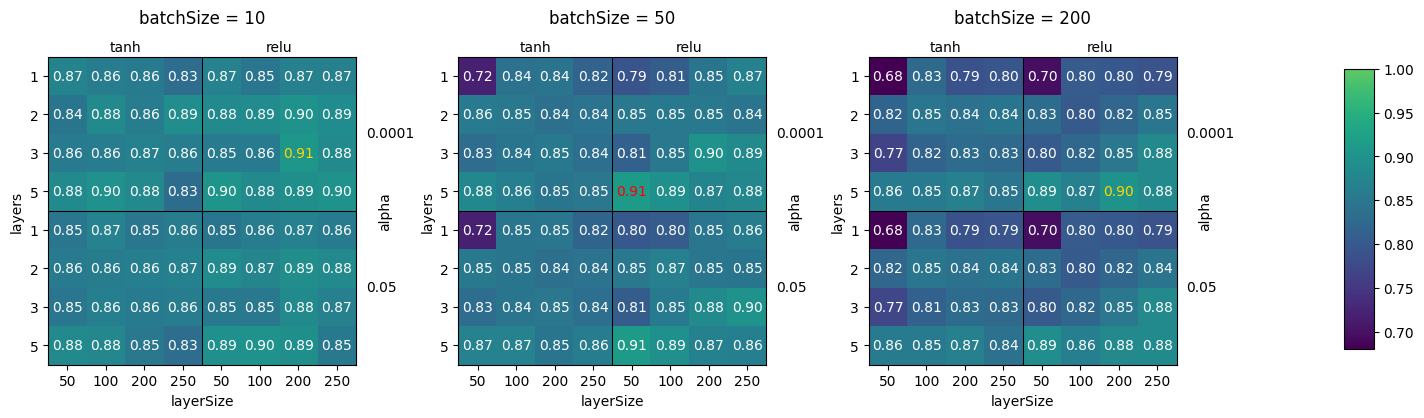

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
115,relu,0.0001,50,"[50, 50, 50, 50, 50]",constant,1000,0.941017,0.913151,0.710311


NO CORRELATED FEATURE


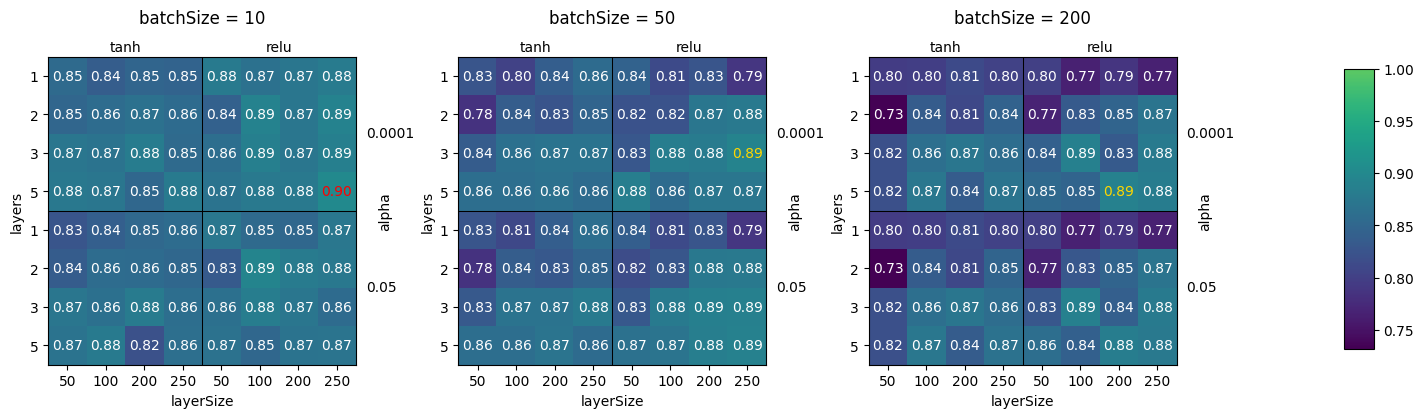

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
111,relu,0.0001,10,"[250, 250, 250, 250, 250]",constant,1000,0.951697,0.901052,15.552117


NO SMOKING


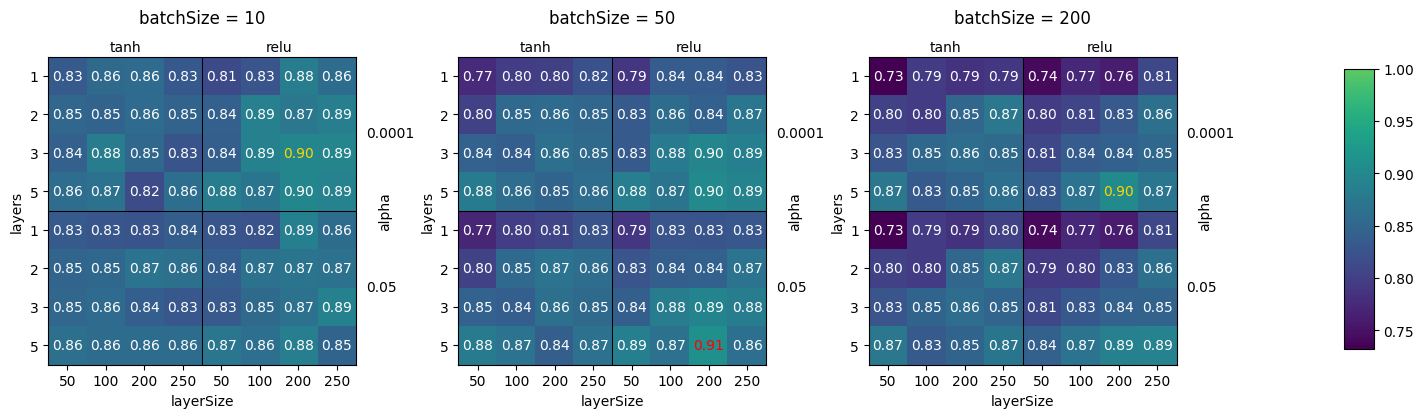

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
171,relu,0.05,50,"[200, 200, 200, 200, 200]",constant,1000,0.920117,0.911109,2.902717


CON PCA


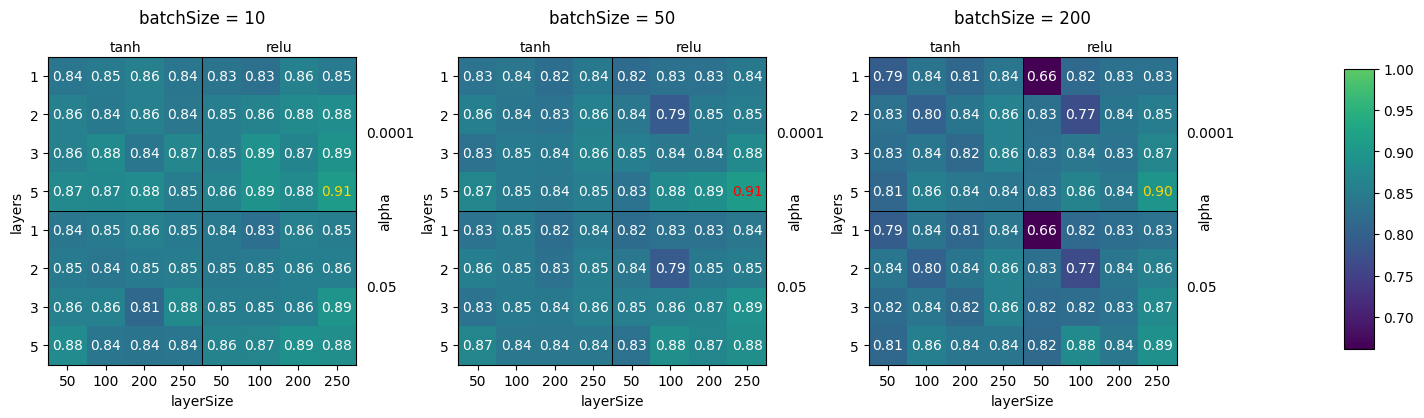

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
127,relu,0.0001,50,"[250, 250, 250, 250, 250]",constant,1000,0.968574,0.908494,7.460747


CLASSICO - OVERSAMPLING


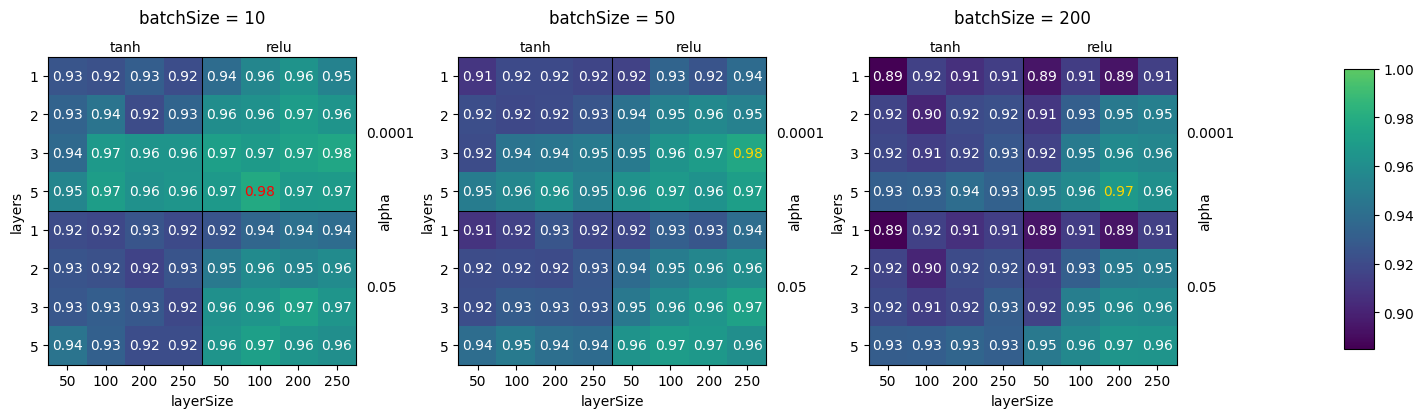

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
103,relu,0.0001,10,"[100, 100, 100, 100, 100]",constant,1000,0.994057,0.978188,4.393646


NO CORRELATED FEATURE - OVERSAMPLING


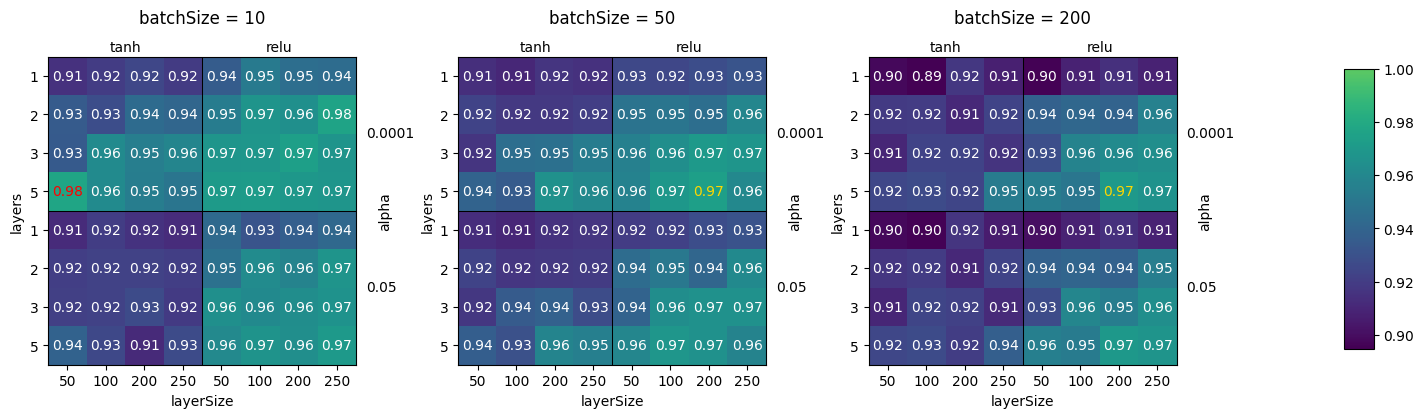

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
3,tanh,0.0001,10,"[50, 50, 50, 50, 50]",constant,1000,0.990342,0.977089,4.261829


NO SMOKING - OVERSAMPLING


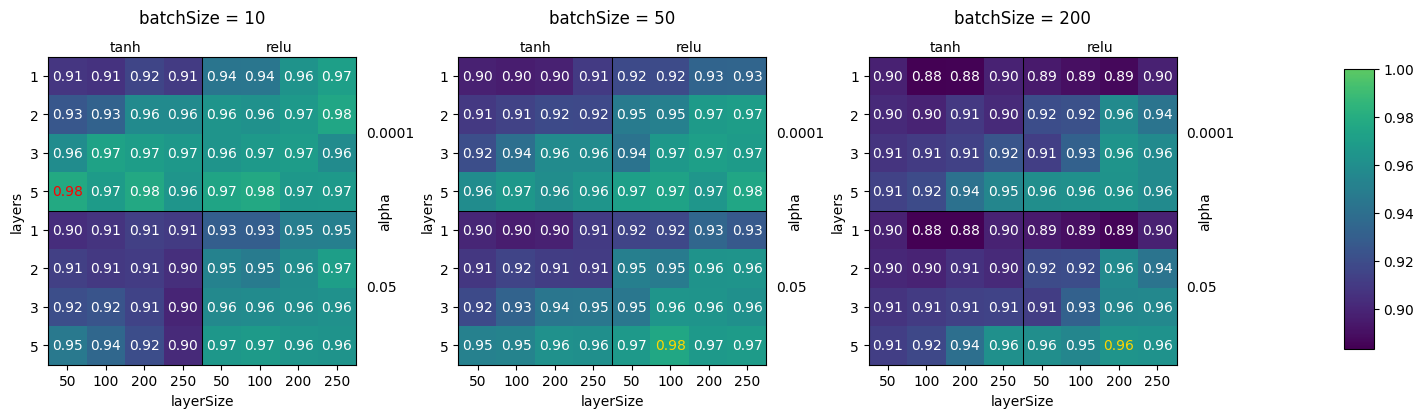

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
3,tanh,0.0001,10,"[50, 50, 50, 50, 50]",constant,1000,0.98735,0.977834,2.83502


CON PCA - OVERSAMPLING


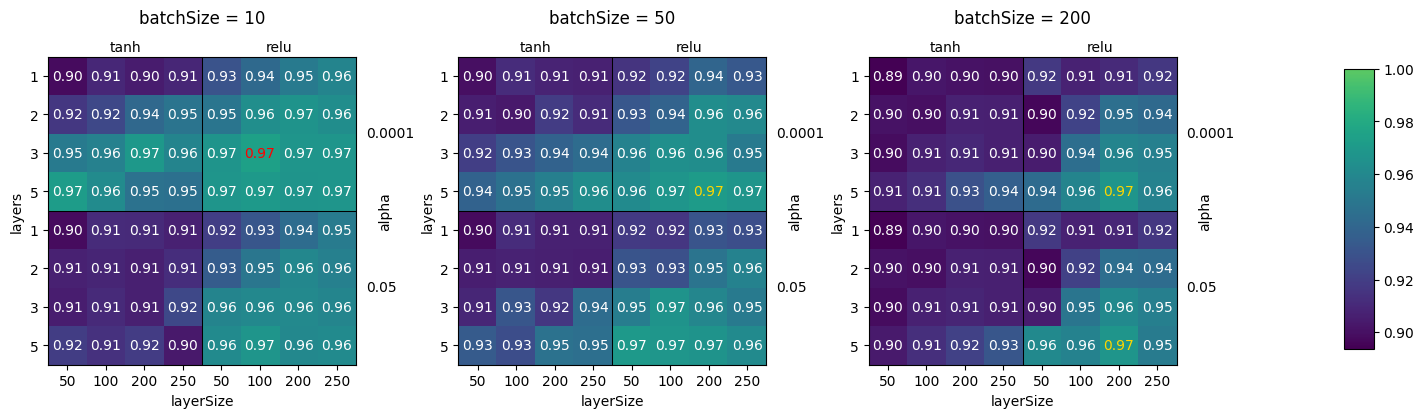

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
102,relu,0.0001,10,"[100, 100, 100]",constant,1000,0.990454,0.97455,2.956938


In [25]:
scoreInterest='mean_test_score'
print('CLASSICO')
bestModel = heatMapGridSearch(results1, GRID, scoreInterest)
print('NO CORRELATED FEATURE')
bestModel_noFeat = heatMapGridSearch(results1_noFeat, GRID, scoreInterest)
print('NO SMOKING')
bestModel_noSmok = heatMapGridSearch(results1_noSmok, GRID, scoreInterest)
print('CON PCA')
bestModel_PCA = heatMapGridSearch(results1_PCA, GRID, scoreInterest)
print('CLASSICO - OVERSAMPLING')
bestModel_os = heatMapGridSearch(results1_os, GRID, scoreInterest)
print('NO CORRELATED FEATURE - OVERSAMPLING')
bestModel_noFeat_os = heatMapGridSearch(results1_noFeat_os, GRID, scoreInterest)
print('NO SMOKING - OVERSAMPLING')
bestModel_noSmok_os = heatMapGridSearch(results1_noSmok_os, GRID, scoreInterest)
print('CON PCA - OVERSAMPLING')
bestModel_PCA_os = heatMapGridSearch(results1_PCA_os, GRID, scoreInterest)

### Raffinamento modello migliore

In [ ]:
#Definizione dei nuovi valori degli iperparametri
layerSize=[75, 100,125,150]
layers=[4,5,8,10]
hiddenLayerSizes=[]
for i in layerSize:
    for j in layers:
        hiddenLayerSizes.append([i]*j)
print(hiddenLayerSizes)
GRID = {
    'hidden_layer_sizes': hiddenLayerSizes,
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.001],  #Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
    'max_iter': [1000],
    'learning_rate': ['constant'], #, 'adaptive'],
    #'n_iter_no_change': [75, 150],
    'batch_size': [8, 10, 25]
}

[[75, 75, 75, 75], [75, 75, 75, 75, 75], [75, 75, 75, 75, 75, 75, 75, 75], [75, 75, 75, 75, 75, 75, 75, 75, 75, 75], [100, 100, 100, 100], [100, 100, 100, 100, 100], [100, 100, 100, 100, 100, 100, 100, 100], [100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [125, 125, 125, 125], [125, 125, 125, 125, 125], [125, 125, 125, 125, 125, 125, 125, 125], [125, 125, 125, 125, 125, 125, 125, 125, 125, 125], [150, 150, 150, 150], [150, 150, 150, 150, 150], [150, 150, 150, 150, 150, 150, 150, 150], [150, 150, 150, 150, 150, 150, 150, 150, 150, 150]]


In [27]:
#Dichiarazione della svm
mlp2_os = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp2_gs_os = GridSearchCV(estimator=mlp2_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp2_gs_os.fit(df_train_scal_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results2_os = pd.DataFrame(mlp2_gs_os.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


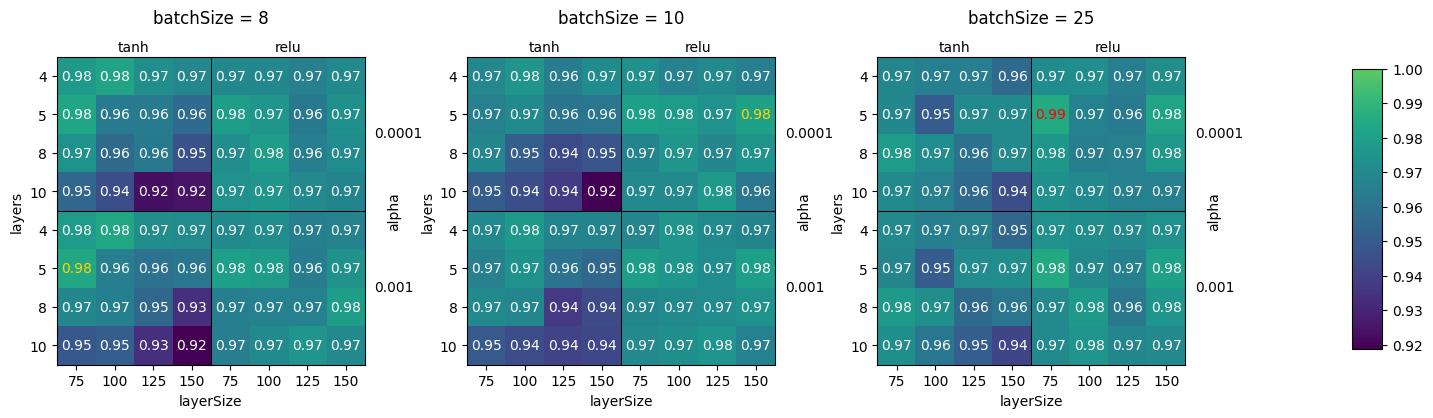

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
129,relu,0.0001,25,"[75, 75, 75, 75, 75]",constant,1000,0.994575,0.985224,1.795914


In [ ]:
#Divisione delle colonne 'layers' e 'layerSize'
results2_os['layers'] = results2_os.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results2_os['layerSize'] = results2_os.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)

#Stampa delle heat map delle grid search
scoreInterest='mean_test_score'
bestModel2_os = heatMapGridSearch(results2_os, GRID, scoreInterest)

#### Secondo raffinamento

In [ ]:
#Definizione dei nuovi valori degli iperparametri
layerSize=[50, 75,100,150]
layers=[4,5,6,7]
hiddenLayerSizes=[]
for i in layerSize:
    for j in layers:
        hiddenLayerSizes.append([i]*j)
print(hiddenLayerSizes)
GRID = {
    'hidden_layer_sizes': hiddenLayerSizes,
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.0005],  #Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
    'max_iter': [1000],
    'learning_rate': ['constant'], #, 'adaptive'],
    #'n_iter_no_change': [75, 150],
    'batch_size': [15, 25, 30]
}

[[50, 50, 50, 50], [50, 50, 50, 50, 50], [50, 50, 50, 50, 50, 50], [50, 50, 50, 50, 50, 50, 50], [75, 75, 75, 75], [75, 75, 75, 75, 75], [75, 75, 75, 75, 75, 75], [75, 75, 75, 75, 75, 75, 75], [100, 100, 100, 100], [100, 100, 100, 100, 100], [100, 100, 100, 100, 100, 100], [100, 100, 100, 100, 100, 100, 100], [150, 150, 150, 150], [150, 150, 150, 150, 150], [150, 150, 150, 150, 150, 150], [150, 150, 150, 150, 150, 150, 150]]


In [33]:
#Dichiarazione della svm
mlp3_os = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp3_gs_os = GridSearchCV(estimator=mlp3_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=KFold(10, random_state=random_seed, shuffle=True),
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp3_gs_os.fit(df_train_scal_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results3_os = pd.DataFrame(mlp3_gs_os.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


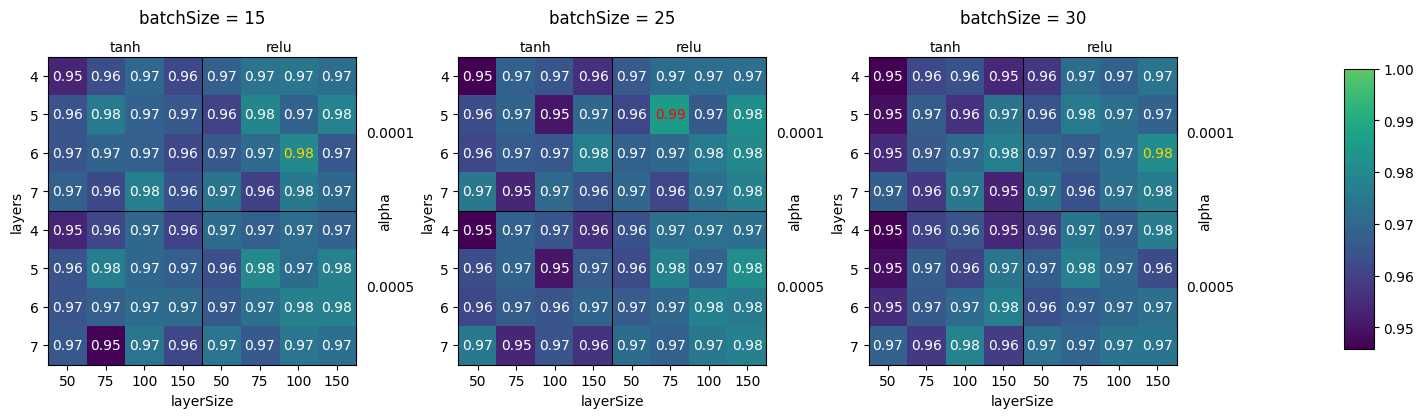

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
117,relu,0.0001,25,"[75, 75, 75, 75, 75]",constant,1000,0.994575,0.985224,1.639348


In [ ]:
#Divisione delle colonne 'layers' e 'layerSize'
results3_os['layers'] = results3_os.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results3_os['layerSize'] = results3_os.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)

#Stampa delle heat map delle grid search
scoreInterest='mean_test_score'
bestModel3_os = heatMapGridSearch(results3_os, GRID, scoreInterest)

### Test del modello migliore

#### Identificazione modello migliore in validation

In [35]:
bestModels_df = pd.DataFrame(np.vstack((bestModel,bestModel_noFeat,bestModel_noSmok,bestModel_PCA, bestModel_os, bestModel_noFeat_os, bestModel_noSmok_os, bestModel_PCA_os, bestModel2_os, bestModel2_os)), index=['Dati originali', 'No feature correlata','No smoking', 'PCA','Dati originali - Oversampling', 'No feature correlata - Oversampling','No smoking - Oversampling', 'PCA - Oversampling','Dati originali - Oversampling (raffinamento)','Dati originali - Oversampling (raffinamento 2)'], columns=bestModel.index)
display(bestModels_df[['mean_test_score', 'mean_fit_time']].rename(columns={'mean_test_score':'f1 score medio su validation', 'mean_fit_time':'Tempo medio addestramento'}))

,f1 score medio su validation,Tempo medio addestramento
Dati originali,0.913151,0.710311
No feature correlata,0.901052,15.552117
No smoking,0.911109,2.902717
PCA,0.908494,7.460747
Dati originali - Oversampling,0.978188,4.393646
No feature correlata - Oversampling,0.977089,4.261829
No smoking - Oversampling,0.977834,2.83502
PCA - Oversampling,0.97455,2.956938
Dati originali - Oversampling (raffinamento),0.985224,1.795914
Dati originali - Oversampling (raffinamento 2),0.985224,1.795914


#### Addestramento dei modelli migliori (per ogni pre-processing) sull'intero insieme di training

In [36]:
#Classico
bestMLP = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel['param_hidden_layer_sizes'], activation=bestModel['param_activation'], alpha=bestModel['param_alpha'], batch_size=bestModel['param_batch_size'], max_iter=bestModel['param_max_iter'], shuffle=True)
start=time.time()
bestMLP.fit(df_train_scal,y_train)
stop=time.time()
bestMLP_fit_time = stop-start

#No correlated feature
bestMLP_noFeat = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_noFeat['param_hidden_layer_sizes'], activation=bestModel_noFeat['param_activation'], alpha=bestModel_noFeat['param_alpha'], batch_size=bestModel_noFeat['param_batch_size'], max_iter=bestModel_noFeat['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_noFeat.fit(df_train_noFeat,y_train)
stop=time.time()
bestMLP_noFeat_fit_time = stop-start

#No smoking
bestMLP_noSmok = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_noSmok['param_hidden_layer_sizes'], activation=bestModel_noSmok['param_activation'], alpha=bestModel_noSmok['param_alpha'], batch_size=bestModel_noSmok['param_batch_size'], max_iter=bestModel_noSmok['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_noSmok.fit(df_train_noSmok,y_train)
stop=time.time()
bestMLP_noSmok_fit_time = stop-start

#PCA
bestMLP_PCA = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_PCA['param_hidden_layer_sizes'], activation=bestModel_PCA['param_activation'], alpha=bestModel_PCA['param_alpha'], batch_size=bestModel_PCA['param_batch_size'], max_iter=bestModel_PCA['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_PCA.fit(df_train_PCA,y_train)
stop=time.time()
bestMLP_PCA_fit_time = stop-start

#Classico - Oversampling
bestMLP_os = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_os['param_hidden_layer_sizes'], activation=bestModel_os['param_activation'], alpha=bestModel_os['param_alpha'], batch_size=bestModel_os['param_batch_size'], max_iter=bestModel_os['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_os.fit(df_train_scal_os,y_train_os)
stop=time.time()
bestMLP_os_fit_time = stop-start

#No correlated feature - Oversampling
bestMLP_noFeat_os = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_noFeat_os['param_hidden_layer_sizes'], activation=bestModel_noFeat_os['param_activation'], alpha=bestModel_noFeat_os['param_alpha'], batch_size=bestModel_noFeat_os['param_batch_size'], max_iter=bestModel_noFeat_os['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_noFeat_os.fit(df_train_noFeat_os,y_train_os)
stop=time.time()
bestMLP_noFeat_os_fit_time = stop-start

#No smoking - Oversampling
bestMLP_noSmok_os = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_noSmok_os['param_hidden_layer_sizes'], activation=bestModel_noSmok_os['param_activation'], alpha=bestModel_noSmok_os['param_alpha'], batch_size=bestModel_noSmok_os['param_batch_size'], max_iter=bestModel_noSmok_os['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_noSmok_os.fit(df_train_noSmok_os,y_train_os)
stop=time.time()
bestMLP_noSmok_os_fit_time = stop-start

#PCA - Oversampling
bestMLP_PCA_os = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_PCA_os['param_hidden_layer_sizes'], activation=bestModel_PCA_os['param_activation'], alpha=bestModel_PCA_os['param_alpha'], batch_size=bestModel_PCA_os['param_batch_size'], max_iter=bestModel_PCA_os['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_PCA_os.fit(df_train_PCA_os,y_train_os)
stop=time.time()
bestMLP_PCA_os_fit_time = stop-start

#Classico - Oversampling (Raffinamento)
bestMLP2_os = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel2_os['param_hidden_layer_sizes'], activation=bestModel2_os['param_activation'], alpha=bestModel2_os['param_alpha'], batch_size=bestModel2_os['param_batch_size'], max_iter=bestModel2_os['param_max_iter'], shuffle=True)
start=time.time()
bestMLP2_os.fit(df_train_scal_os,y_train_os)
stop=time.time()
bestMLP2_os_fit_time = stop-start

#### Applicazione dei modelli ai dati del test set.

In [37]:
# DATI ORIGINALI
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP,df_train_scal,y_train,'training')
perf_mlp,cmat_mlp,mlp_predict_time = performances(bestMLP,df_test_scal,y_test,'test')
metrics_scal = pd.concat([perf_trainval_mlp,perf_mlp])

# NO FEATURE CORRELATA
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_noFeat,df_train_noFeat,y_train,'training')
perf_mlp,cmat_mlp_noFeat,mlp_predict_time = performances(bestMLP_noFeat,df_test_noFeat,y_test,'test')
metrics_noFeat = pd.concat([perf_trainval_mlp,perf_mlp])

# NO SMOKING
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_noSmok,df_train_noSmok,y_train,'training')
perf_mlp,cmat_mlp_noSmok,mlp_predict_time = performances(bestMLP_noSmok,df_test_noSmok,y_test,'test')
metrics_noSmock = pd.concat([perf_trainval_mlp,perf_mlp])

# CON PCA
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_PCA,df_train_PCA,y_train,'training')
perf_mlp,cmat_mlp_PCA,mlp_predict_time = performances(bestMLP_PCA,df_test_PCA,y_test,'test')
metrics_PCA = pd.concat([perf_trainval_mlp,perf_mlp])

comparison_normal = pd.concat([metrics_scal, metrics_noFeat,metrics_noSmock,metrics_PCA], axis=0, keys=['Dati originali', 'No feature correlata','No smoking','Con PCA'])

In [38]:
#DATI ORIGINALI - OVERSAMPLING
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_os,df_train_scal_os,y_train_os,'training')
perf_mlp,cmat_mlp_os,mlp_predict_time = performances(bestMLP_os,df_test_scal_os,y_test_os,'test')
metrics_scal_os = pd.concat([perf_trainval_mlp,perf_mlp])

# NO FEATURE CORRELATA - OVERSAMPLING
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_noFeat_os,df_train_noFeat_os,y_train_os,'training')
perf_mlp,cmat_mlp_noFeat_os,mlp_predict_time = performances(bestMLP_noFeat_os,df_test_noFeat_os,y_test_os,'test')
metrics_noFeat_os = pd.concat([perf_trainval_mlp,perf_mlp])

# NO SMOKING - OVERSAMPLING
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_noSmok_os,df_train_noSmok_os,y_train_os,'training')
perf_mlp,cmat_mlp_noSmok_os,mlp_predict_time = performances(bestMLP_noSmok_os,df_test_noSmok_os,y_test_os,'test')
metrics_noSmock_os = pd.concat([perf_trainval_mlp,perf_mlp])

# CON PCA - OVERSAMPLING
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_PCA_os,df_train_PCA_os,y_train_os,'training')
perf_mlp,cmat_mlp_PCA_os,mlp_predict_time = performances(bestMLP_PCA_os,df_test_PCA_os,y_test_os,'test')
metrics_PCA_os = pd.concat([perf_trainval_mlp,perf_mlp])

comparison_os = pd.concat([metrics_scal_os, metrics_noFeat_os,metrics_noSmock_os,metrics_PCA_os], axis=0, keys=['Dati originali', 'No feature correlata','No smoking','Con PCA'])

In [39]:
#DATI ORIGINALI - OVERSAMPLING (RAFFINAMENTO)
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP2_os,df_train_scal_os,y_train_os,'training')
perf_mlp,cmat_mlp2_os,mlp_predict_time = performances(bestMLP2_os,df_test_scal_os,y_test_os,'test')
metrics2_scal_os = pd.concat([perf_trainval_mlp,perf_mlp])

In [40]:
comparison = pd.concat([comparison_normal, comparison_os], axis=1, keys=['Dataset originale', 'Oversampling'])
display(comparison)

Dataset originale                                \
                                       Accuracy Precision    Recall        F1   
Dati originali       training          0.967577  0.950704  0.918367  0.934256   
                     test              0.938776  0.911765  0.837838  0.873239   
No feature correlata training          0.965870  0.931973  0.931973  0.931973   
                     test              0.952381  0.968750  0.837838  0.898551   
No smoking           training          0.960751  0.918919  0.925170  0.922034   
                     test              0.931973  0.909091  0.810811  0.857143   
Con PCA              training          0.996587  0.993197  0.993197  0.993197   
                     test              0.938776  0.937500  0.810811  0.869565   

                              Oversampling                                
                                  Accuracy Precision    Recall        F1  
Dati originali       training     0.988610  0.997680  0.979499  0.988506  
                     test         0.952381  0.941176  0.864865  0.901408  
No feature correlata training     0.993166  0.986517  1.000000  0.993213  
                     test         0.986395  0.972973  0.972973  0.972973  
No smoking           training     0.987472  0.979821  0.995444  0.987571  
                     test         0.945578  0.853659  0.945946  0.897436  
Con PCA              training     0.993166  0.995423  0.990888  0.993151  
                     test         0.952381  0.941176  0.864865  0.901408

In [41]:
comparison_raff = pd.concat([metrics_scal_os, metrics2_scal_os], axis=0, keys=['Dati originali - Overs.', 'Dati originali - Overs. (raffinamento)'])
display(comparison_raff)

Accuracy  Precision  \
Dati originali - Overs.                training  0.988610   0.997680   
                                       test      0.952381   0.941176   
Dati originali - Overs. (raffinamento) training  0.979499   0.995294   
                                       test      0.938776   0.966667   

                                                   Recall        F1  
Dati originali - Overs.                training  0.979499  0.988506  
                                       test      0.864865  0.901408  
Dati originali - Overs. (raffinamento) training  0.963554  0.979167  
                                       test      0.783784  0.865672

Rappresentazione delle confusion matrix

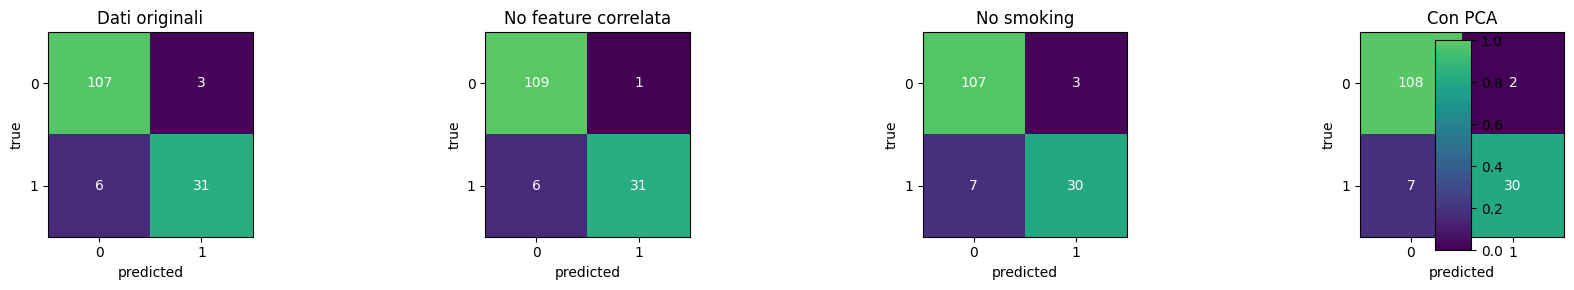

OVERSAMPLING


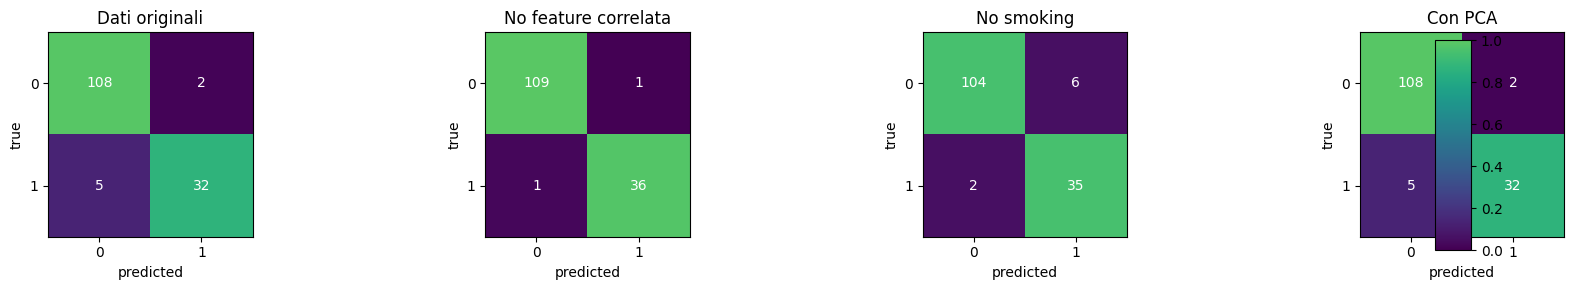

In [42]:
heatMapConstr([cmat_mlp,cmat_mlp_noFeat,cmat_mlp_noSmok,cmat_mlp_PCA], ['Dati originali', 'No feature correlata','No smoking','Con PCA'])
print('OVERSAMPLING')
heatMapConstr([cmat_mlp_os,cmat_mlp_noFeat_os,cmat_mlp_noSmok_os,cmat_mlp_PCA_os], ['Dati originali', 'No feature correlata','No smoking','Con PCA'])


RAFFINAMENTO


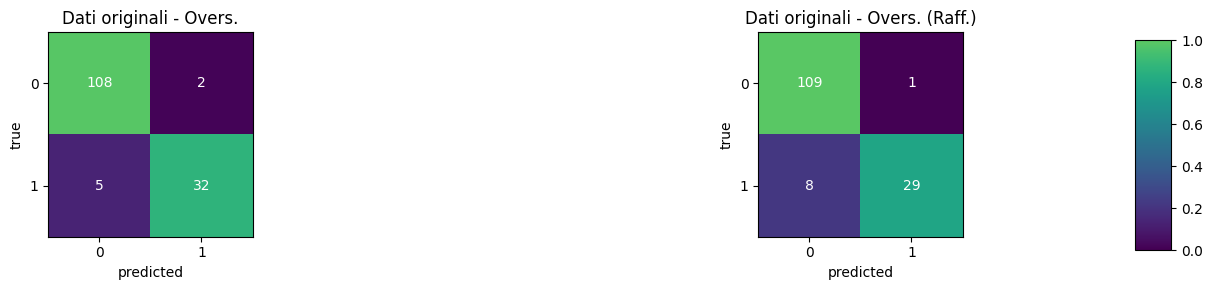

In [43]:
print('RAFFINAMENTO')
heatMapConstr([cmat_mlp_os,cmat_mlp2_os], ['Dati originali - Overs.', 'Dati originali - Overs. (Raff.)'])